# Exercise 6: Logistic regression and classification

You will be pleased to find that the framework for logistic regression is very similar to that of the linear regression. For this exercise we use the `GLM` method in the statsmodels library (https://www.statsmodels.org/stable/glm.html), in which we specify the model via the model matrix `X`. There is also an equivalent method, `glm`, that allows specification via the formula API just as for linear regression. The sklearn library has also a `LogisticRegression` method, but note that it by default regularizes the estimated coefficients using an L2-penalty. To run a classical logistic regression with parameters estimated by maximum likelihood, you will need to set `penalty = 'none'`.

In [131]:
# Import relevant packages
import numpy as np
from pandas import read_csv, DataFrame
from math import log, sqrt
import math
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns 
from mlxtend.plotting import plot_decision_regions

## Getting familiar with the model

### Translation between log-odds and probabilities


Implement the standard logistic function `sigma` as well as its inverse, the logit function. Make a plot of `sigma`

Explain how these two functions are used to transform a probability into log-odds and vice versa.

In [57]:
def sigma(x):
    return 1/ (1+ math.e**(-x))

def logit(x):
    return math.log(x / (1-x))

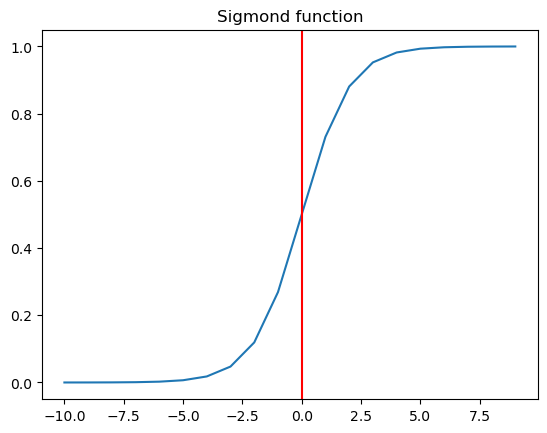

In [58]:
x = np.arange(-10,10)
y_sigma = sigma(x)

fig,ax = plt.subplots()
ax.plot(x, y_sigma)
ax.set_title('Sigmond function')
plt.axvline(x=0, color='red');

Predicted value is a probability. Sigmoid maps any number to prob.

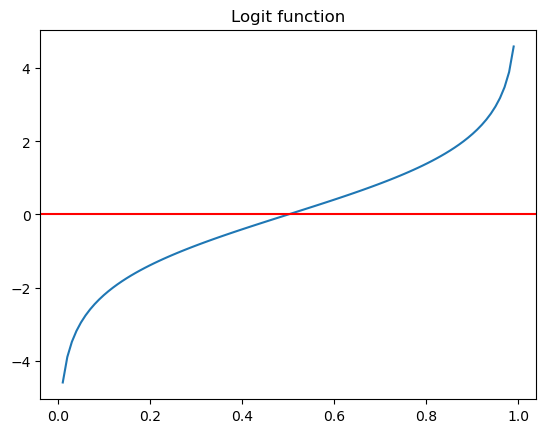

In [59]:
def logit(p):
    return np.log(p / (1-p))

p = np.linspace(0.01, 0.99, 100) # range of values between 0 and 1
y_logit = logit(p)

fig,ax = plt.subplots()
ax.plot(p, y_logit)
ax.set_title('Logit function')
plt.axhline(y=0, color='red');

Logit = logodds. Maps probablities to real numbers. 

Consider a logistic regression model with a single feature $X$ where $\beta_0=0.3$ and $\beta_1=0.7$. 

A) What is the probability of Y=1 when X=5?

B) What are the odds of Y=1 for X=5?

C) What is the *odds ratio* comparing odds of Y=1 when X=8 to the odds when X=5?

In [60]:
# A) P(Y=1 | X=5)

lr =  0.3 + 0.7 * 5  
prob = sigma(lr)
print(prob)


0.9781187290638694


In [61]:
# B) Odds Y=1 | X=5

def odds(p):
    return p/ (1-p)

# same way
odds = lambda p: p/(1-p)

odd_5 = odds(prob)
print(odd_5)

44.70118449330062


Given X=5, it is 44 times more likely that Y=1 than 0

In [62]:
# C) Odds ratio for X = 8

lr =  0.3 + 0.7 * 8  
prob_8 = sigma(lr)
odd_8 = odds(prob_8)

ratio = odd_8/odd_5
print(ratio)


8.16616991256797


Y = 1 is 8 times more likely to happens if X=8 compared to X=5.

## Load data

Load the `Default` data set from the ISLwR book, which is a simulated data set containing information on ten thousand customers. We will recreate the results in section 4.3. The aim with the data is to predict which customers will default on their credit card debt.

`default`: A binary variable with levels No and Yes indicating whether the customer defaulted on their debt.

`student` A factor with levels No and Yes indicating whether the customer is a student

`balance` The average balance that the customer has remaining on their credit card after making their monthly payment

`income` Income of customer

In [132]:
df = read_csv('Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [64]:
df.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

In [133]:
# Transform default and student to numerical format
df['default'] = preprocessing.LabelEncoder().fit_transform(df['default'])
df['student'] = preprocessing.LabelEncoder().fit_transform(df['student'])
df.head()


,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


Split data into a training set and a test set

In [66]:
# how to split? first EDA analysis...

default_counts = df['default'].value_counts()
print(default_counts)

# 30 times more NO, important to do a balanced split (stratify)

default
0    9667
1     333
Name: count, dtype: int64


In [67]:
train, test = train_test_split(df, test_size=0.2, stratify=df['default'])
print(train.shape, test.shape)

(8000, 4) (2000, 4)


In [68]:
df = df[['balance', 'income', 'student','default']] #to change order (not important)

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


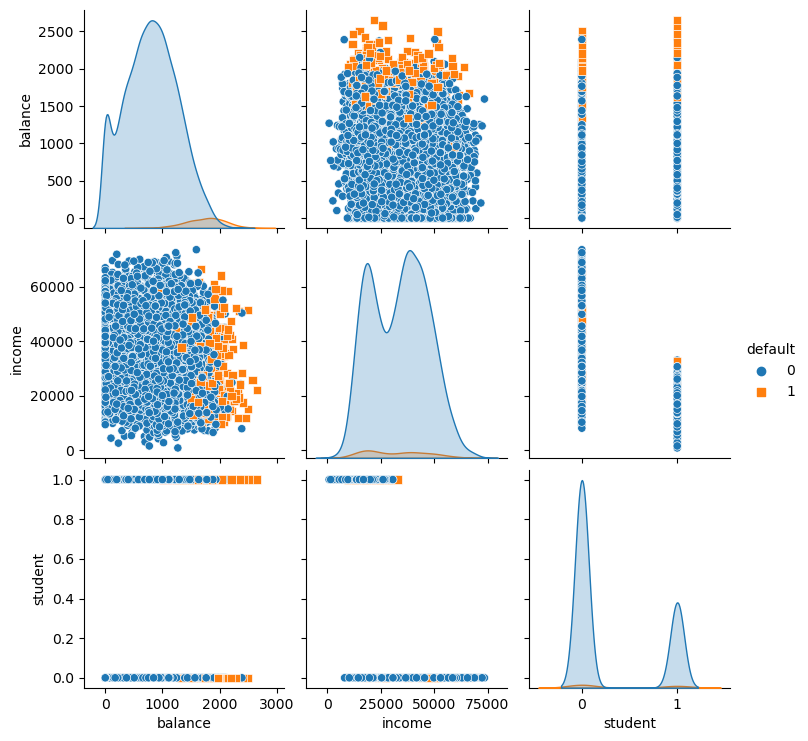

In [69]:
sns.pairplot(df, hue='default', diag_kind='kde', markers=["o", "s"])
plt.show()

## Fitting the logistic regression

A logistic regression model is specified as

`sm.GLM(y, X, family=sm.families.Binomial(link = sm.families.links.logit()))`

Here we have specified
1. the outcome variable Y
2. the model matrix X, which specifies how features enter the model
3. the *family* of distributions for Y, which is the *binomial distribution*
4. the *link function*, which is the *logit* for performing logistic regression. This link function is the default for the binomial, so we can leave it out.

As for linear regression, the model is fitted with the `fit` method. From the resulting object you can obtain parameters and the fitted values on the training data. You predict with `predict` method and you can see the output via `summary` method.

Fit a logistic regression model, `M1`, that has `balance` as the only feature, and check your results against Table 4.1 in ISLwR.

!!! For each of the three models, write down the formula for the estimated probabilities using the estimated coefficients. Write down also the formula for the estimated log odds.

In [70]:
X = train['balance']
y = train['default']

X = sm.add_constant(X)

m1 = sm.GLM(y, X, family=sm.families.Binomial()).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -640.84
Date:                Thu, 12 Sep 2024   Deviance:                       1281.7
Time:                        08:50:09   Pearson chi2:                 3.81e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1232
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6015      0.402    -26.392      0.000     -11.389      -9.814
balance        0.0055      0.000     22.290      0.000       0.005       0.006
==============================================================================
"""

In [134]:
# With formula API
m1 = smf.glm('default ~ balance', train,family=sm.families.Binomial() ).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -640.84
Date:                Thu, 12 Sep 2024   Deviance:                       1281.7
Time:                        12:55:30   Pearson chi2:                 3.81e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1232
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6015      0.402    -26.392      0.000     -11.389      -9.814
balance        0.0055      0.000     22.290      0.000       0.005       0.006
==============================================================================
"""

Formula for estimated probabilities using estimated coefficiients: 

$$
P(default| \text{balance}) = \sigma(0.0053\times balance - 10.3244)
$$

Estimated log odds:

$$
\log(\frac{P(default| \text{balance})}{ 1 - P(default| \text{balance})}) = 0.0053\times balance - 10.3244
$$

Fit the exact same model, but using `LogisticRegression` from sklearn, taking care that you turn off regularization.

In [72]:
m1_sk = LogisticRegression(random_state=0, penalty='none')
m1_sk.fit(train[['balance']], train['default']) ## double [] to create df

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none', random_state=0)

Fit another model, `M2`, that takes a single *categorical* feature, `student`, and check the results against Table 4.2

In [73]:
m2 = smf.glm('default ~ student', train,family=sm.families.Binomial() ).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1159.3
Date:                Thu, 12 Sep 2024   Deviance:                       2318.6
Time:                        08:50:10   Pearson chi2:                 8.00e+03
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001904
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5459      0.081    -43.942      0.000      -3.704      -3.388
student        0.5067      0.127      3.979      0.000       0.257       0.756
==============================================================================
"""

Pseudo Rsquared is worse than before. Student variable does not impact significantly on prediction

Formula for estimated probabilities using estimated coefficiients: 

$$
P(default| \text{student}) = \sigma(0.3853\times student - 3.4980)
$$

Estimated log odds:

$$
\log(\frac{P(default| \text{student})}{ 1 - P(default| \text{student})}) = 0.3853\times student - 3.4980
$$

Fit a model, `M3`, that has an interaction between `student` and `balance`.

In [92]:
m3 = smf.glm('default ~ I(balance*student)', train,family=sm.families.Binomial()).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1087.5
Date:                Thu, 12 Sep 2024   Deviance:                       2175.1
Time:                        08:51:17   Pearson chi2:                 9.13e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01965
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.9486      0.090    -43.994      0.000      -4.125      -3.773
I(balance * student)     0.0012    8.9e-05     13.340      0.000       0.001       0.001
========================================================================================
"""

Formula for estimated probabilities using estimated coefficiients: 

$$
P(default| \text{student*balance}) = \sigma(0.0011\times student \times balance - 3.8701)
$$

Estimated log odds:

$$
\log(\frac{P(default| \text{student*balance})}{ 1 - P(default| \text{student})}) = 0.0011\times student \times balance - 3.8701
$$

## Prediction 

Fitted values --the mean response-- are obtained as for the linear regression. However a main difference is that the mean is not used directly as a prediction of Y. Rather, we choose a threshold $\alpha$ and predict $Y=1$ whenever $P(Y=1|X) > \alpha$. Usually we take $\alpha = 0.5$, unless we specifically wish to incur a "higher cost" for some kinds of misclassifications.

Using $\alpha = 0.5$, compute the training error rate (proportion of wrong classifications) for models M1, M2, and M3.

In [93]:
models = [m1,m2,m3]
true_train = train['default']

for i,m in enumerate(models):
    #predict in train
    probs = m.predict(train)
    pred_class = (probs > 0.5).astype(int)

    #compute missclassifications
    miss = (pred_class != true_train).sum()
    training_error = miss/len(true_train)
    print(f"Training error model {i+1}: {training_error}")

Training error model 1: 0.027875
Training error model 2: 0.03325
Training error model 3: 0.03325


Compute the test error for the three models and compare to the training error.

In [136]:
true_test = test['default']

for i,m in enumerate(models):
    #predict in test
    probs = m.predict(test)
    pred_class = (probs > 0.5).astype(int)

    #compute missclassifications
    miss = (pred_class != true_test).sum()
    test_error = miss/len(true_test)
    print(f"Test error model {i+1}: {test_error}")

Test error model 1: 0.0255
Test error model 2: 0.0335
Test error model 3: 0.0335


Compare the three models by their AIC: Based on this criterion, which would you choose?

In [137]:
for i,m in enumerate(models):
    aic = m.aic
    print(f"AIC model {i+1}: {aic}")

AIC model 1: 1285.6761077780561
AIC model 2: 2322.57903004762
AIC model 3: 2179.0970336916353


### Decision regions and the decision boundary between them

In model M1, describe the *decision regions*, i.e. for which values of the feature (income) you would predict that an individual defaults, and for which you would predict not default. 

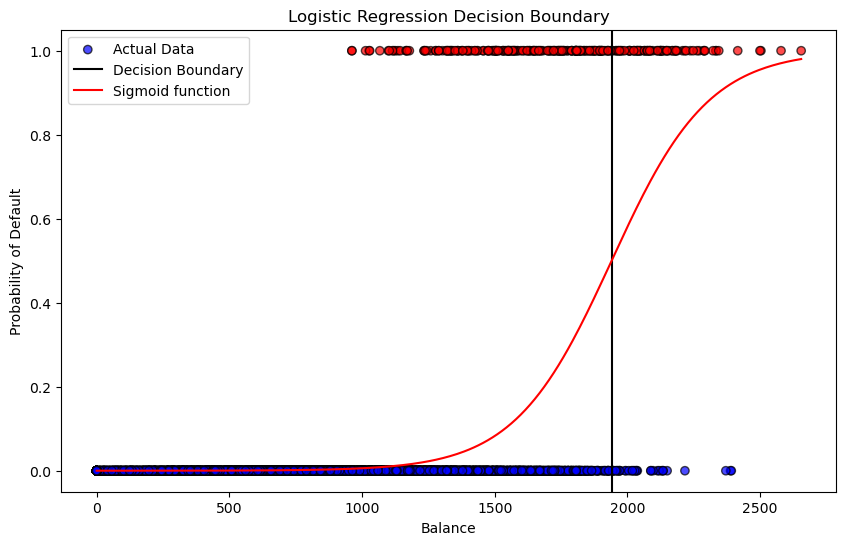

In [96]:
intercept = m1.params['Intercept']
coef_balance = m1.params['balance']

probs = m1.predict(train)
classes = (probs > 0.5).astype(int)

# range of balance to plot a smooth sigmoid function
balance_range = np.linspace(train['balance'].min(), train['balance'].max(), 300)
z = intercept + coef_balance * balance_range
sigmoid = 1/ (1 + np.exp(-z))

plt.figure(figsize=(10, 6))
plt.scatter(train['balance'], train['default'], c=train['default'], cmap='bwr', edgecolors='k', alpha=0.7, label='Actual Data')

decision_boundary_balance = -intercept / coef_balance
plt.axvline(x=decision_boundary_balance, color='black', label='Decision Boundary')

plt.plot(balance_range, sigmoid, color='red', label= 'Sigmoid function')

plt.xlabel('Balance')
plt.ylabel('Probability of Default')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()

Fit a model, `M4`, with two continuous features `income` and `balance`.

In [97]:
m4 = smf.glm('default ~ balance + income', train ,family=sm.families.Binomial()).fit()

Make a plot of your feature space (i.e. with income and balance on the axes) as follows: 
Use the model to predict the class for each point in a fine grid over the two features. Plot the points of the grid and colour them according to class: Blue for default = Yes, Red for default = No.

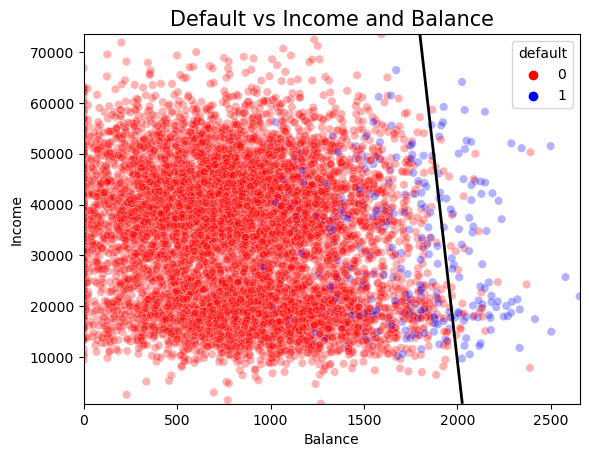

In [127]:
#grid
balance_min, balance_max = train['balance'].min(), train['balance'].max()
income_min, income_max = train['income'].min(), train['income'].max()

balance_range = np.linspace(balance_min, balance_max, 100)
income_range = np.linspace(income_min, income_max, 100)
balance_grid, income_grid = np.meshgrid(balance_range, income_range)

grid_flat = DataFrame({
    'balance': balance_grid.ravel(),
    'income': income_grid.ravel()
})

grid_flat['pred_prob'] = m4.predict(grid_flat)

prob_grid = grid_flat['pred_prob'].values.reshape(balance_grid.shape)

plt.figure()
sns.scatterplot(
    x='balance', 
    y='income', 
    hue='default', 
    data=train,
    palette={0: 'red', 1: 'blue'}, 
    alpha=0.3, 
    legend=True
)

#for plotting decicion boundary 
plt.contour(balance_grid, income_grid, prob_grid, levels=[0.5], colors='black', linewidths=2)

plt.title('Default vs Income and Balance', fontsize=15)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

Add a quadratic term to the model and make the same plot as before. You should now obtain a non-linear decision boundary (although if you plotted against the squared feature, you would indeed get a linear boundary!)

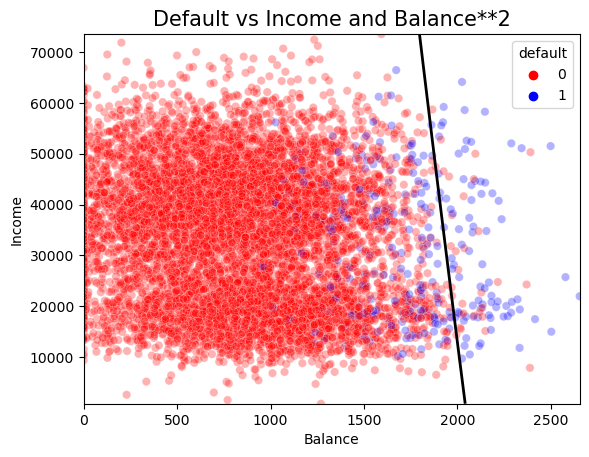

In [129]:
m5 = smf.glm('default ~ balance + I(balance**2) + income', train ,family=sm.families.Binomial()).fit()

grid_flat['pred_prob_5'] = m5.predict(grid_flat)

prob_grid_5 = grid_flat['pred_prob_5'].values.reshape(balance_grid.shape)

plt.figure()
sns.scatterplot(
    x='balance', 
    y='income', 
    hue='default', 
    data=train,
    palette={0: 'red', 1: 'blue'}, 
    alpha=0.3, 
    legend=True
)

#for plotting decicion boundary 
plt.contour(balance_grid, income_grid, prob_grid_5, levels=[0.5], colors='black', linewidths=2)

plt.title('Default vs Income and Balance**2', fontsize=15)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

In [130]:
print(m4.params)
print(m5.params)

Intercept   -11.345024
balance       0.005592
income        0.000017
dtype: float64
Intercept         -1.289814e+01
balance            7.686399e-03
I(balance ** 2)   -6.738769e-07
income             1.713723e-05
dtype: float64


## Interpreting a model

A) For model M1, predict the probability of defaulting for an individual with a balance of 1,000 and for an individual with balance 2,000. Try to compute the prediction from scratch yourself as well as with the `predict` method. You should obtain the same as in section 4.3.3.

In [84]:
new = DataFrame({'balance': [1000,2000]})
probs = m1.predict(new)
print(probs)

0    0.005840
1    0.581083
dtype: float64


In [85]:
m1.params

Intercept   -10.601498
balance       0.005464
dtype: float64

In [86]:
# with formula... 

sigmoid = lambda x: 1/(1 + math.e**(-x))
lr = lambda x: m1.params['Intercept'] + m1.params['balance']*x  

p1, p2 = sigmoid(lr(1000)), sigmoid(lr(2000))
print("Balance=1000 prob default: ", p1)
print("Balance=2000 prob default: ", p2)

Balance=1000 prob default:  0.005840171171362663
Balance=2000 prob default:  0.5810834618824563


B) Considering the same two individuals, how many times higher are the odds of defaulting for the individual with low balance?

In [87]:
odds_ratio = odds(p2)/odds(p1)
print("Odds ratio Customer 2 (balance=2000) vs Customer 1 (balance=1000): {:.3f}".format(odds_ratio))

Odds ratio Customer 2 (balance=2000) vs Customer 1 (balance=1000): 236.125


It is 236 times more likely that a customer with balance=2000 will deefault compared with a customer with balance =1000

C) For model M2, what are the probabilities of defaulting for students and non-students respectively? You should obtain the same as in section 4.3.3.

In [88]:
new = DataFrame({'student': [1,0]})
probs = m2.predict(new)
print('Student prob of default:', probs.iloc[0])
print('NO student prob of default:', probs.iloc[1])

Student prob of default: 0.04568527918781591
NO student prob of default: 0.02803406671477978


Student is more likely to default.

D) In M1, what is the interpretation of the coefficient for `balance`?

In [89]:
m1.params

Intercept   -10.601498
balance       0.005464
dtype: float64

Coefficients represent the increase in the log-odds after a one-unit increase in balance. Higher balance amounts are associated with higher probability of defaulting. 

E) (optional) In model M3, compute the odds-ratio comparing the odds of defaulting for a student with high balance (2,000) and a student with a low balance (1,000). Do the same for a non-student. Note that the odds ratio differs -- this is a consequence of the *interaction* term!

In [138]:
m3.params

Intercept              -3.948627
I(balance * student)    0.001187
dtype: float64

In [115]:
new = DataFrame({
    'balance': [2000,1000,2000,1000],
    'student': [1,1,0,0]
})

probs3 = m3.predict(new)
print('Student + balance=2000:', probs3.iloc[0])
print('Student + balance=1000:', probs3.iloc[1])
print('NO student + balance=2000:', probs3.iloc[2])
print('NO student + balance=1000:', probs3.iloc[3])

Student + balance=2000: 0.1715712047913856
Student + balance=1000: 0.059435991825923386
NO student + balance=2000: 0.018916426878782533
NO student + balance=1000: 0.018916426878782533


In [113]:
ratio_student = odds(probs3.iloc[0])/odds(probs3.iloc[1])
ratio_no_student = odds(probs3.iloc[3])/odds(probs3.iloc[2])

print("STUDENTS odds ratio high vs low balance: {:.3f}".format(ratio_student))
print("NO STUDENTS odds ratio high vs low balance: {:.3f}".format(ratio_no_student))

STUDENTS odds ratio high vs low balance: 3.277
NO STUDENTS odds ratio high vs low balance: 1.000


In [139]:
m3_ = smf.glm('default ~ balance*student', train,family=sm.families.Binomial()).fit()
print(m3_.params)

print('Probabilities:')
probs3_ = m3_.predict(new)
print('Student + balance=2000:', probs3_.iloc[0])
print('Student + balance=1000:', probs3_.iloc[1])
print('NO student + balance=2000:', probs3_.iloc[2])
print('NO student + balance=1000:', probs3_.iloc[3])

Intercept         -10.815380
balance             0.005762
student            -0.254941
balance:student    -0.000223
dtype: float64
Probabilities:
Student + balance=2000: 0.5018638617071072
Student + balance=1000: 0.003944688398689822
NO student + balance=2000: 0.6702013180940499
NO student + balance=1000: 0.006348662741128464


In [119]:
ratio_student = odds(probs3_.iloc[0])/odds(probs3_.iloc[1])
ratio_no_student = odds(probs3_.iloc[2])/odds(probs3_.iloc[3])

print("STUDENTS odds ratio high vs low balance: {:.3f}".format(ratio_student))
print("NO STUDENTS odds ratio high vs low balance: {:.3f}".format(ratio_no_student))

STUDENTS odds ratio high vs low balance: 254.395
NO STUDENTS odds ratio high vs low balance: 318.059


In both cases, high balance increase the odds of deafult. However, for non-students the effect of the balance in the default is stronger. 